# My most popular songs in a 2D plot

Below is the final result of the last cell, it is a plot done with Plotly Express, where I embedded a link to a song preview file.

As such you can as well hover over the points to know which song it is or click on it to listen to it.

In [13]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

fig = px.scatter(
    df_top,
    x='proj_x',
    y='proj_y',
    hover_name='fullname',
    hover_data=['hover_text'],
    text=df_top['preview_url'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color='clusters',
    color_discrete_sequence=px.colors.qualitative.Safe,
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
)

# Data Preparation

In [1]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt

pd.set_option('max_columns', None)

In [2]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [3]:
col = [
    'added_at',
    'album.id',
    'album.images.0.height',
    'album.images.0.url',
    'album.images.0.width',
    'album.name',
    'album.release_date',
    'album.release_date_precision',
    'artists.id',
    'artists.name',
    'duration_min',
    'id',
    'external_urls.spotify',
    'name',
    'popularity',
    'preview_url',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

feat = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to:
* I add **duration** and **popularity** for this graph

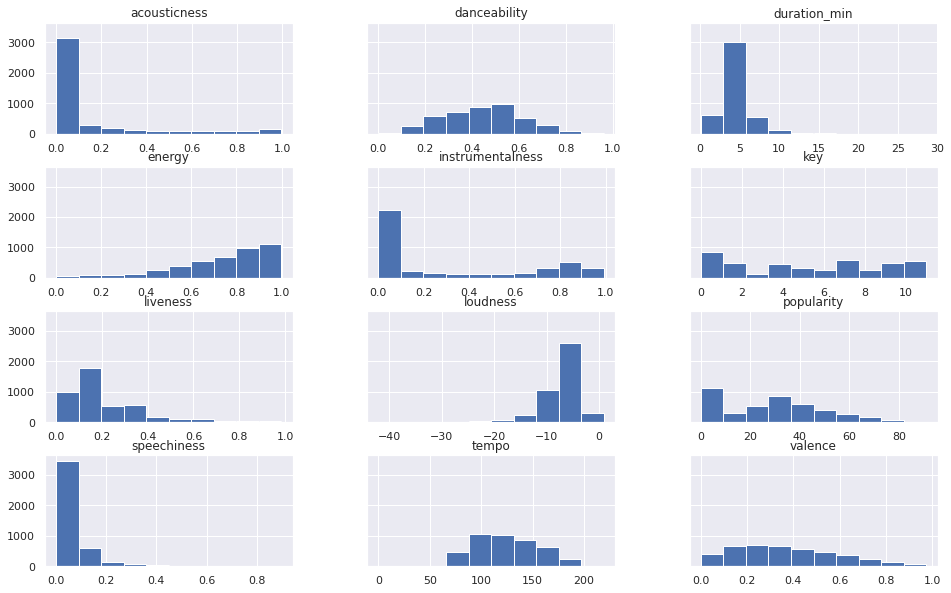

In [4]:
df[feat+['duration_min', 'popularity']].hist(sharey=True, figsize=(16, 10));

# Projection
There is 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionnality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

UMAP(metric='mahalanobis', n_neighbors=100, random_state=0, verbose=1)
Construct fuzzy simplicial set
Tue Jun 30 01:50:37 2020 Finding Nearest Neighbors
Tue Jun 30 01:50:37 2020 Building RP forest with 8 trees
Tue Jun 30 01:50:38 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
Tue Jun 30 01:51:06 2020 Finished Nearest Neighbor Search
Tue Jun 30 01:51:09 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to spec

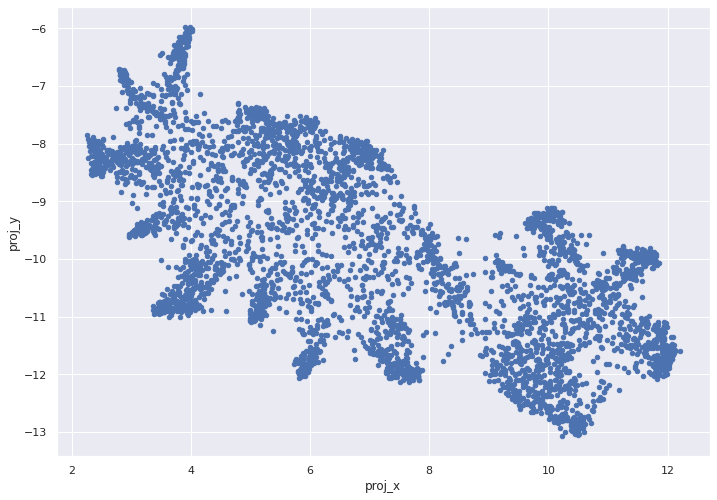

In [5]:
from umap import UMAP
mdl_proj = UMAP(
    n_neighbors=100,
    metric='mahalanobis',
    verbose=1,
    random_state=0
)

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(df[feat]))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

Let's see a bit where the supergenre calculated previously are in this projection

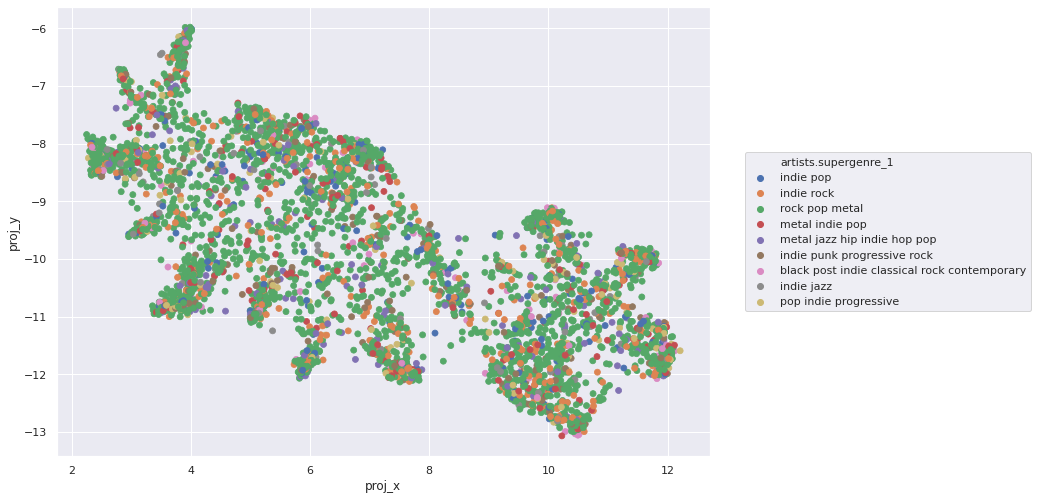

In [6]:
g = sns.scatterplot(
    data=df,
    x='proj_x',
    y='proj_y',
    hue='artists.supergenre_1',
    legend='full',
    cmap=sns.color_palette('husl'),
    edgecolor=None
);
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1);

This is expected, and even as intended, I am not focusing on a music genre, but on a music audio, for example a group of "sad" songs of multilple genres...

# Clustering
I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
the size of 16 seems the magic (other size around does not give similar clusters number and size)

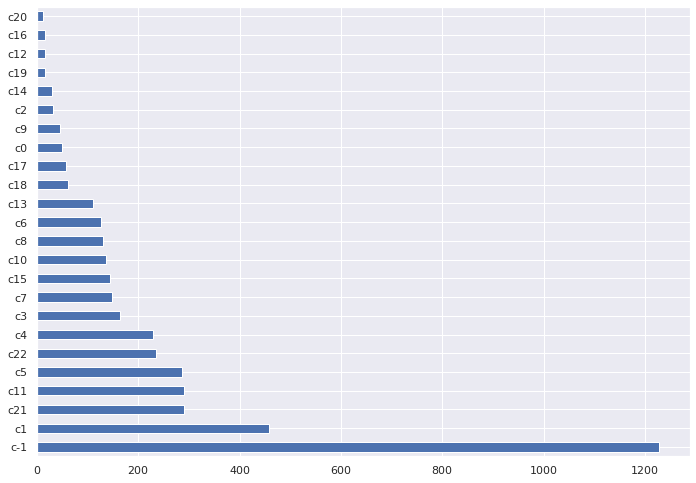

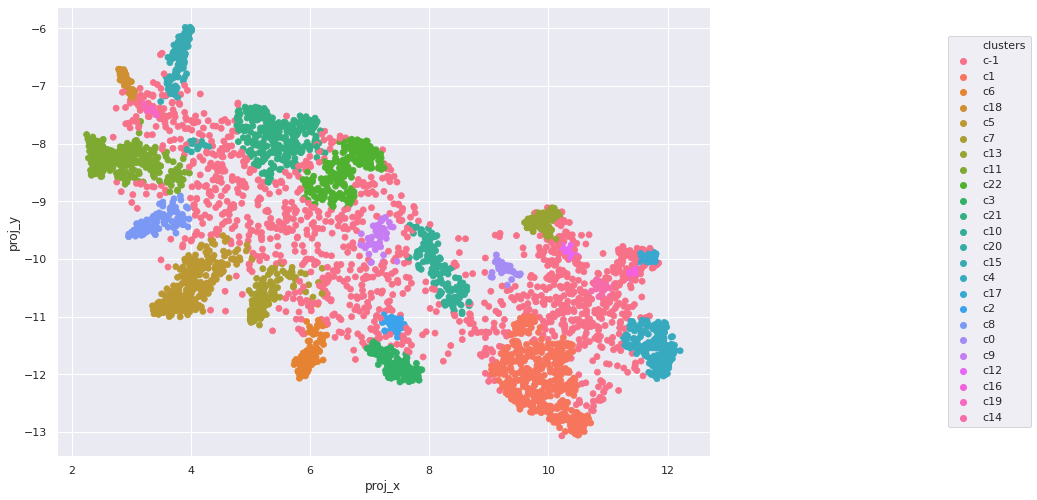

In [7]:
from hdbscan import HDBSCAN

df['clusters'] = HDBSCAN(min_cluster_size=10, min_samples=20)\
                    .fit_predict(df[['proj_x', 'proj_y']], min)
df['clusters'] = df['clusters'].map(lambda x: f'c{x}')

plt.figure()
df['clusters'].value_counts().plot(kind='barh');

plt.figure()
g = sns.scatterplot(
    data=df,
    x='proj_x',
    y='proj_y',
    hue='clusters',
    legend='full',
    cmap=sns.color_palette('husl'),
    edgecolor=None
);
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1);

# Visualization
Let's see if those clusters make sense by printing each 10 most popular songs

In [8]:
# count of most popular songs to analyse
top_n = 3

In [9]:
col = feat+[
    'clusters',
    'proj_x',
    'proj_y',
    'popularity',
    'duration_min',
    'name',
    'artists.name',
    'album.name',
    'artists.genres',
    'artists.supergenres',
    'artists.supergenre_1',
    'external_urls.spotify',
    'preview_url'
]

df_top = df[col].groupby('clusters').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(top_n)
)

df_top.sample(5)

danceability  energy  key  loudness  speechiness  acousticness  \
clusters                                                                        
c20      698          0.692   0.458   11    -9.461       0.0403       0.06350   
c16      462          0.579   0.812    1    -6.509       0.0693       0.00114   
c8       1128         0.438   0.805    8    -6.237       0.0624       0.00255   
c9       4201         0.528   0.619    5    -8.444       0.0295       0.10300   
c4       2607         0.556   0.913    0    -2.360       0.0437       0.01930   

               instrumentalness  liveness  valence    tempo clusters  \
clusters                                                               
c20      698           0.516000    0.1360    0.350  150.695      c20   
c16      462           0.003330    0.1150    0.278  152.002      c16   
c8       1128          0.000057    0.0842    0.564  113.253       c8   
c9       4201          0.095100    0.6230    0.759  151.997       c9   
c4       2607          0.000009    0.3460    0.730   96.184       c4   

                  proj_x     proj_y  popularity  duration_min  \
clusters                                                        
c20      698    4.303106  -8.055945          52      4.444050   
c16      462   11.436288 -10.266608          67      3.729100   
c8       1128   3.141707  -9.462543          77      4.013333   
c9       4201   7.061044  -9.425927          53      3.657883   
c4       2607  12.021427 -11.889826          76      4.702667   

                                   name               artists.name  \
clusters                                                             
c20      698                  Identikit              ['Radiohead']   
c16      462                  Pardon Me                ['Incubus']   
c8       1128  All Along the Watchtower           ['Jimi Hendrix']   
c9       4201                     Alibi             ['Mansionair']   
c4       2607           Dani California  ['Red Hot Chili Peppers']   

                       album.name  \
clusters                            
c20      698   A Moon Shaped Pool   
c16      462        Make Yourself   
c8       1128   Electric Ladyland   
c9       4201         Shadowboxer   
c4       2607    Stadium Arcadium   

                                                  artists.genres  \
clusters                                                           
c20      698   ['alternative rock', 'art rock', 'melancholia'...   
c16      462   ['alternative metal', 'alternative rock', 'fun...   
c8       1128  ['acid rock', 'album rock', 'blues rock', 'cla...   
c9       4201  ['aussietronica', 'electropop', 'indie electro...   
c4       2607  ['alternative rock', 'funk metal', 'funk rock'...   

                                       artists.supergenres  \
clusters                                                     
c20      698                            ['rock pop metal']   
c16      462   ['rock pop metal', 'pop indie progressive']   
c8       1128             ['rock pop metal', 'indie rock']   
c9       4201  ['rock pop metal', 'pop indie progressive']   
c4       2607  ['rock pop metal', 'pop indie progressive']   

                artists.supergenre_1  \
clusters                               
c20      698          rock pop metal   
c16      462   pop indie progressive   
c8       1128             indie rock   
c9       4201  pop indie progressive   
c4       2607  pop indie progressive   

                                           external_urls.spotify  \
clusters                                                           
c20      698   https://open.spotify.com/track/3LhtqibvTtjOUrz...   
c16      462   https://open.spotify.com/track/1Y13csEpu3TK5gQ...   
c8       1128  https://open.spotify.com/track/2aoo2jlRnM3A0Ny...   
c9       4201  https://open.spotify.com/track/1ObT98WfVsnJoL5...   
c4       2607  https://open.spotify.com/track/10Nmj3JCNoMeBQ8...   

                                                     preview_url 

An interactive plot with px would help see where the songs are in the projection and what they are

In [10]:
df_top['hover_text'] = df_top.apply(
    lambda x:
        f'<br>'+
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>' +
        f'Album: {x["album.name"]}<br>' +
        # f'Genres: {x["artists.genres"]}<br>'+
        # f'Super Genres: {x["artists.supergenres"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>',
    axis=1
)

df_top['fullname'] = df_top.apply(
    lambda x: f'{x["name"]}, {x["artists.name"]}<br>',
    axis=1
)

df_top['size'] = df_top['popularity'].apply(lambda x: np.log10(x+1))

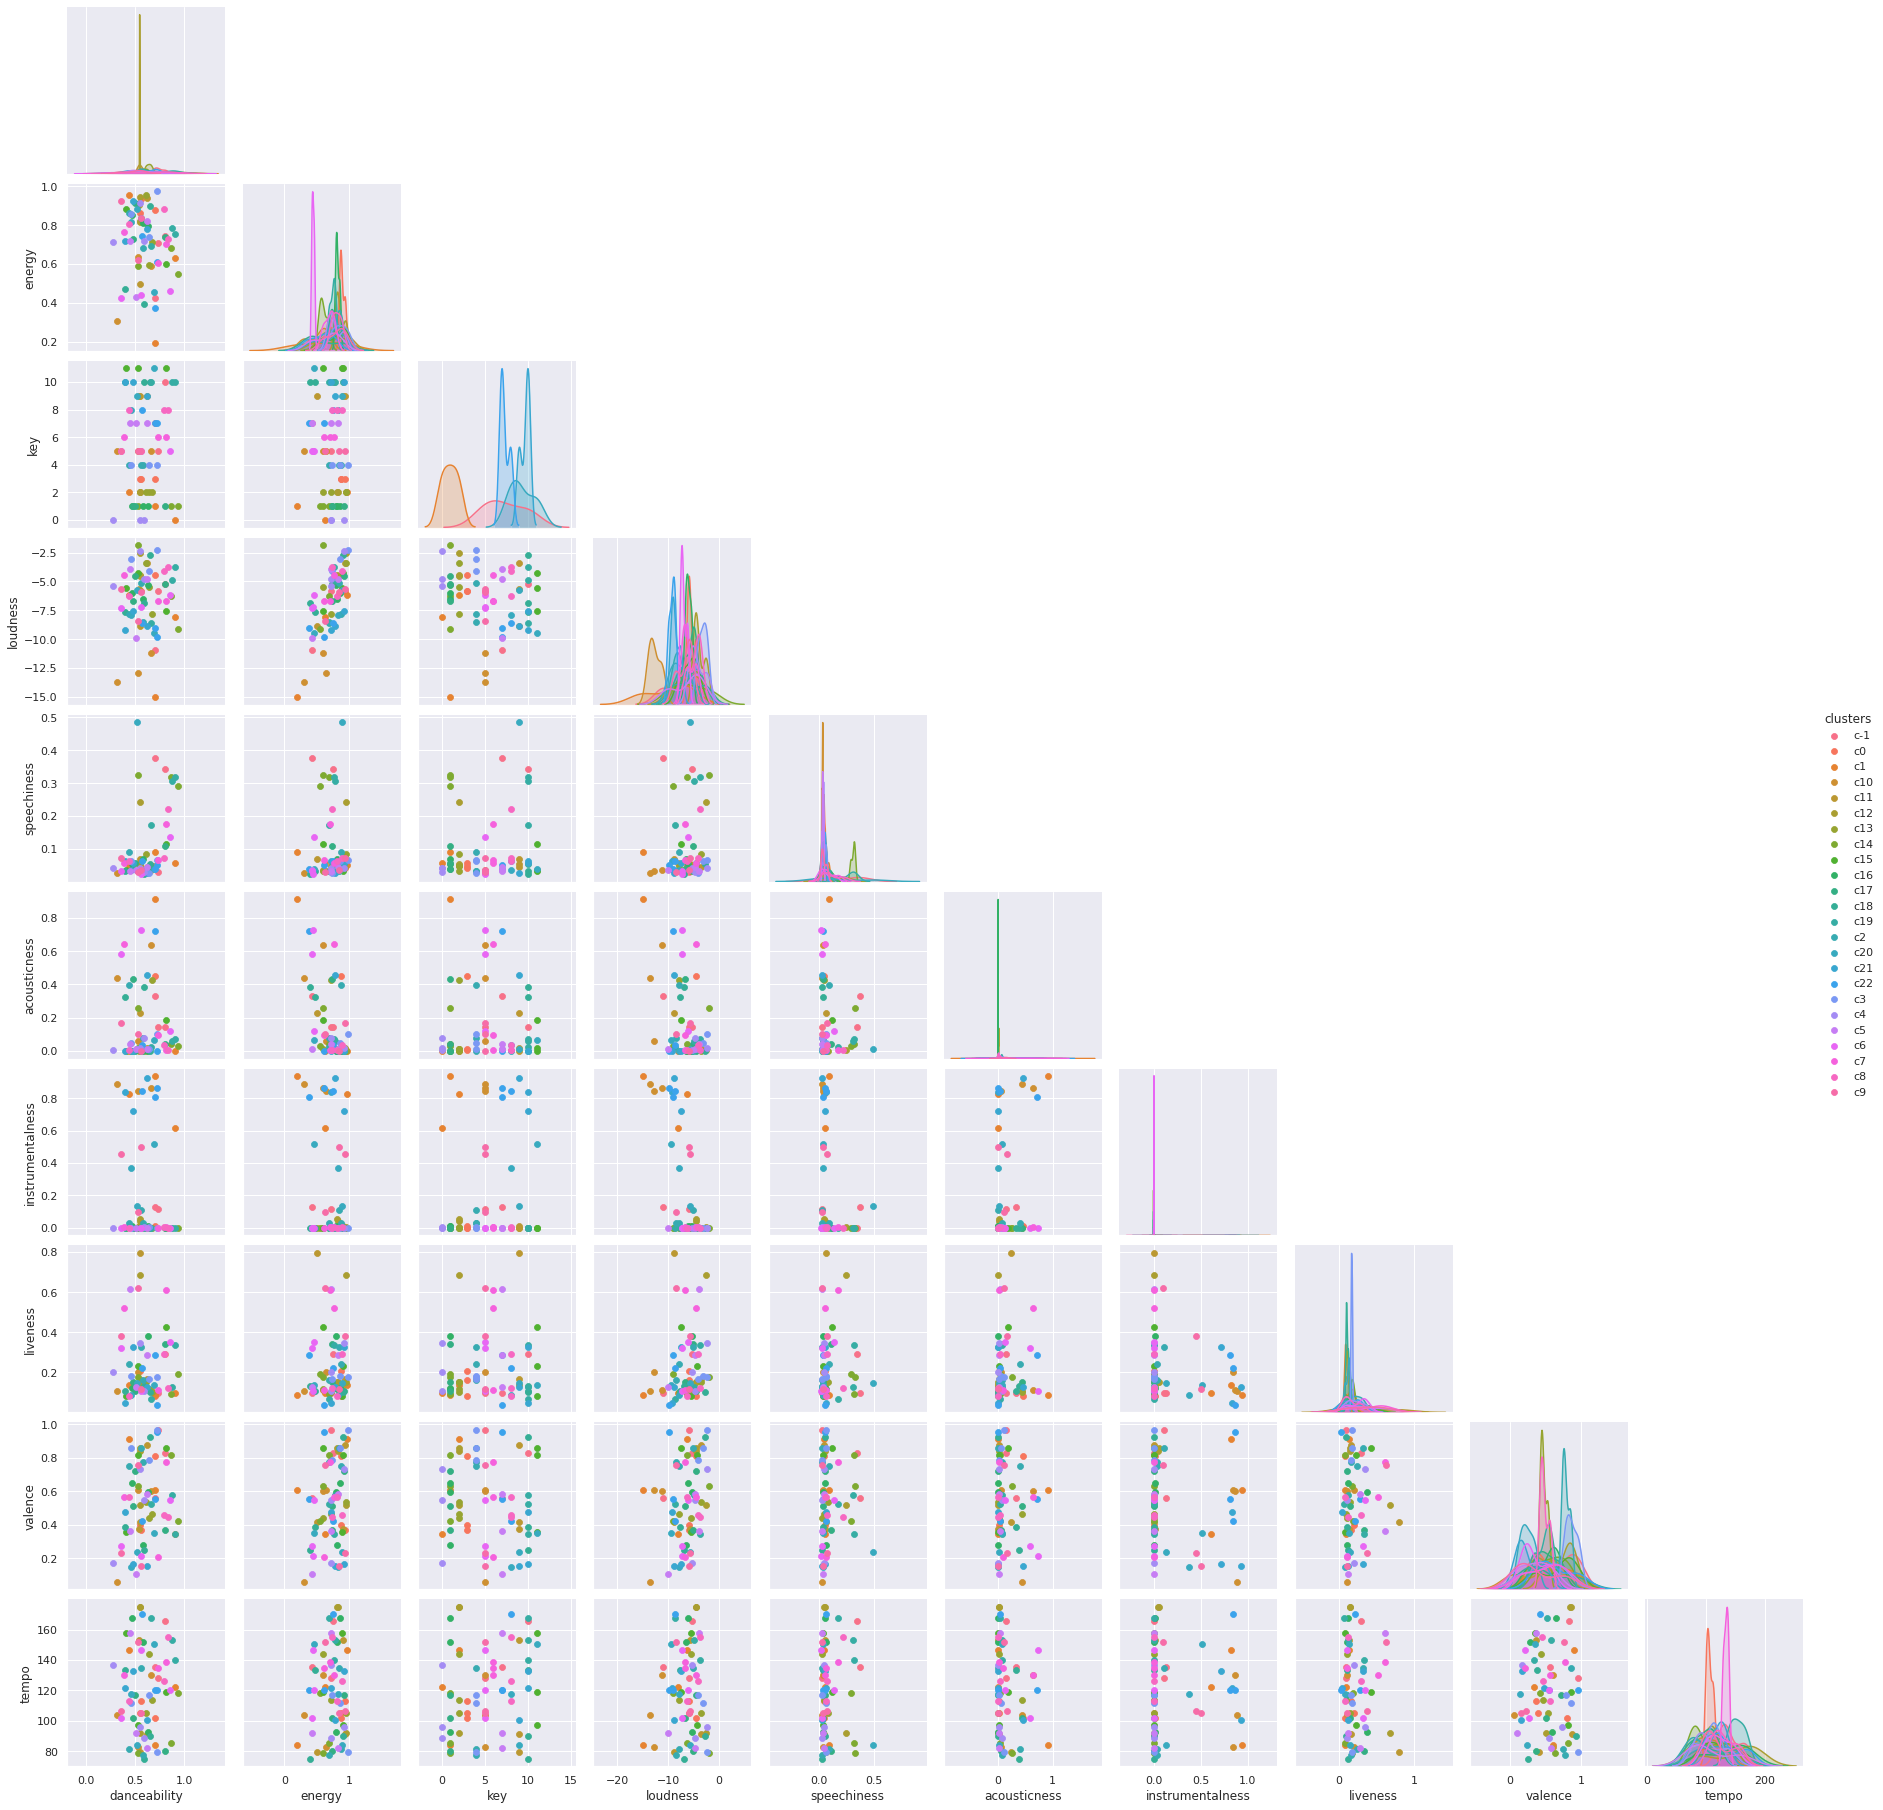

In [11]:
sns.pairplot(
    df_top[feat+['clusters']],
    hue='clusters',
    diag_kind='kde',
    plot_kws=dict(edgecolor=None),
    corner=True,
);

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

fig = px.scatter(
    df_top,
    x='proj_x',
    y='proj_y',
    hover_name='fullname',
    hover_data=['hover_text'],
    text=df_top['preview_url'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color='clusters',
    color_discrete_sequence=px.colors.qualitative.Safe,
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
)